# Capstone project (Part 2) - IBM Data Science Professional Certificate

### For better view of folium maps displaying data points on the Toronto geographical map, go here: 
### ADDD HERE!!!

## In this part of the project we will provide recommendation for opening a new restaurant (~3 star) in Toronto, utilizing
1. KMeans unsupervised Machine Learning (ML) algorithm
2. Tableau software
3. Folium maps
4. Wellbeing data provided by Toronto (https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/wellbeing-toronto/ 
5. Property pricing data obtained from kaggle (https://www.kaggle.com/mnabaee/ontarioproperties)
6. Foursquare API for obtaining recommended venues and restaurants in Toronto and their popularity via the amount of likes.

## Links to sections
1. [Exploring, finding, visualizing best Borough and top recommended venues in Toronto](#best_brgh)
2. [Exploring property/estate pricing in the Toronto area for opening restaurant](#prop_price)
3. [Exploring crime, demographics to select preferable areas in Toronto for opening restaurant](#pref_area_crime_demo)
4. [Analyzing, visualizing preferable areas and competing restaurants in Toronto to finalize recommendations](#map_pref_area)
5. [Final recommedations for opening a restaurant in Toronto](#final_rec)

###############################################################################################################################

## Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from math import cos, asin, sqrt

#Requests allows you to send organic, grass-fed HTTP/1.1 requests, without the need for manual labor.
import requests
from bs4 import BeautifulSoup

# library to handle JSON files
import json 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Importing the geodesic module from the library 
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


###############################################################################################################################
<a id='best_brgh'></a>

## 1. Exploring, finding, visualizing best Borough and top recommended venues in Toronto

### Scrape wikipedia page, extract table data from this webpage and make Pandas dataframe. Extracting data from the Toronto Postcode wiki page and making a data frame from it
- Beautiful Soup is a Python package for parsing HTML and XML documents. It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping. Prettify() function in BeautifulSoup will enable us to view how the tags are nested in the document.
- https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
#requests.get(url).text will ping a website and return you HTML of the website.
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(website_url,'lxml')
My_table = soup.find('table',{'class':'wikitable sortable'})

#all "tr" tag in a list
tag = My_table.findAll('tr') 

# extrating out data from these tags and making a pandas dataframe from it
pst_list = []
count = 1

while count <= (len(tag)-1):
    
    pst_code = tag[count].findAll('td')[0].get_text()
    brgh = tag[count].findAll('td')[1].get_text()
    neigh = tag[count].findAll('td')[2].get_text()
    
    pst_list.append([pst_code,brgh,neigh.strip()])
    count = count+1
    
df = pd.DataFrame(pst_list)
df.columns = ['Postcode', 'Borough', 'Neighbourhood']

# Ignore cells with a borough that is Not assigned.
df = df[df['Borough'] != "Not assigned"].reset_index(drop=True)

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
mask = (df['Neighbourhood'] == "Not assigned")
idx = df[mask].index.values.astype(int)[0]               # Since there is only one entry
df.iloc[idx]['Neighbourhood'] = df.iloc[idx]['Borough']

# More than one neighborhood can exist in one postal code area, hence we are joining them by for those postcodes
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

# To confirm neighbourhoods belonging to single postcode are all collected, print out some samples
print("Sample rows showing collection of neighbourhoods under Postcode")
display(df[(df['Postcode'] == 'M4B') | (df['Postcode'] == 'M1R') | (df['Postcode'] == 'M5A') | (df['Postcode'] == 'M1B')])

# Final dataframe
print("\n")
print("Below is the FINAL scraped dataframe of shape "+str(df.shape))
display(df.head())

Sample rows showing collection of neighbourhoods under Postcode


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
11,M1R,Scarborough,"Maryvale, Wexford"
35,M4B,East York,"Woodbine Gardens, Parkview Hill"
53,M5A,Downtown Toronto,Harbourfront




Below is the FINAL scraped dataframe of shape (103, 3)


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Loading geographical coordinates for the Toronto Postcodes and appending to the dataframe.

In [3]:
df_cords = pd.read_csv("Geospatial_Coordinates.csv").drop(columns=['Postal Code'])
df['Latitude'] = df_cords['Latitude']
df['Longitude'] = df_cords['Longitude']
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Displaying Neighbourhoods and Postcodes for Toronto

In [4]:
# Unique Boroughs in the dataset
print("Unique Boroughs in the dataframe\n")
print(df["Borough"].unique())

# Boroughs in the Toronto
print("")
print("")
print("Boroughs in Toronto")
df_toto = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)

print("shape of Toronto dataframe is "+str(df_toto.shape))
df_toto.head()

Unique Boroughs in the dataframe

['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' "Queen's Park" 'Mississauga'
 'Etobicoke']


Boroughs in Toronto
shape of Toronto dataframe is (38, 5)


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Obtaining Latitude and Longitude of Toronto using geopy python library

In [5]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
toto_latitude = location.latitude
toto_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toto_latitude, toto_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create map of Toronto using Folium and plotting Postcode coodinates. Label of each point gives info about the Postcode and the Borough

In [6]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toto_latitude, toto_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, postcode in zip(df_toto['Latitude'], df_toto['Longitude'], df_toto['Borough'], df_toto['Postcode']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### We can cluster these points via KMeans Clustering algorithm using the sklearn library
- Using Unsupervised ML algorithm - KMeans, group the postcodes into 2 differernt clusters based on proximity

In [7]:
kmeans_pst = KMeans(n_clusters=2, random_state=30).fit(df_toto[['Latitude','Longitude']])
df_toto["Cluster"] = kmeans_pst.predict(df_toto[['Latitude','Longitude']])

print(kmeans_pst.cluster_centers_)

df_toto.head()

[[ 43.658162   -79.36771749]
 [ 43.67977494 -79.42036114]]


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1


### Displaying clusters obtained from KMeans on the map of Toronto. 
- Pink pinpoint marker represents the Toronto Center coordinates. 
- Red points indicate Postcodes belonging to Cluster 0
- Blue points indicate same for Cluster 1. 
- Red and Blue pinpoint markers represents the center of these clusters obtained from KMeans

In [8]:
# create map of Toronto using latitude and longitude values
new_map_toronto = folium.Map(location=[toto_latitude, toto_longitude], zoom_start=11)

# add colored markers corresponding to different clusters
for lat, lng, borough, postcode, cluster in zip(df_toto['Latitude'], df_toto['Longitude'], df_toto['Borough'], df_toto['Postcode'], df_toto['Cluster']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    if cluster == 0:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=1,
            parse_html=False).add_to(new_map_toronto)
    if cluster == 1:
            folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=1,
            parse_html=False).add_to(new_map_toronto)

tooltip = 'Click me!'

folium.Marker([kmeans_pst.cluster_centers_[0][0], kmeans_pst.cluster_centers_[0][1]], icon=folium.Icon(color='red'), popup='<b>Postcode Cluster 0</b>').add_to(new_map_toronto)
folium.Marker([kmeans_pst.cluster_centers_[1][0], kmeans_pst.cluster_centers_[1][1]], icon=folium.Icon(color='blue'), popup='<b>Postcode Cluster 1</b>').add_to(new_map_toronto)
folium.Marker([toto_latitude, toto_longitude], icon=folium.Icon(color='pink'), popup='<b>Toronto Center</b>').add_to(new_map_toronto)


new_map_toronto

### Define function to calculate distance given coordinates using geopy library

In [9]:
def dist(lat,long,center):
    dist = geodesic((lat,long), center).meters
    return dist

### Created separate dataframe for each cluster and calculated mean distance of data points in each cluster to the center of that cluster

In [10]:
# Make separate dataframes for each cluster
df_cluster0 = df_toto[df_toto["Cluster"] == 0]
df_cluster1 = df_toto[df_toto["Cluster"] == 1]

cluster0_center = (kmeans_pst.cluster_centers_[0][0], kmeans_pst.cluster_centers_[0][1])
cluster1_center = (kmeans_pst.cluster_centers_[1][0], kmeans_pst.cluster_centers_[1][1])

df_cluster0['Dist. from Center in meters'] = df_cluster0.apply(lambda x: dist(x['Latitude'],x['Longitude'],cluster0_center),axis=1)
df_cluster1['Dist. from Center in meters'] = df_cluster1.apply(lambda x: dist(x['Latitude'],x['Longitude'],cluster1_center),axis=1)

mean_clus0_dist = round(df_cluster0['Dist. from Center in meters'].mean())
mean_clus1_dist = round(df_cluster1['Dist. from Center in meters'].mean())

print("mean distance (m) from center in Cluster 0 is: "+ str(mean_clus0_dist))
print("mean distance (m) from center in Cluster 1 is: "+ str(mean_clus1_dist))

mean distance (m) from center in Cluster 0 is: 2293
mean distance (m) from center in Cluster 1 is: 3487


### Define Foursquare Credentials and Version using credentials saved in a .json file

In [11]:
with open('../credentials.json') as f:
    data = json.load(f)
    CLIENT_ID = data['clientID']
    CLIENT_SECRET = data['clientSecret']
    VERSION = data['version']

### Define methods that will generate foursquare API endpoint URL to extract venue information
   1. ven_exp_url provides URL for exploring the recommended venues around a given latitude and longitude values
   2. likes_ven_url provides URL which gives number of likes given by people for a particular venue.
   3. get_category_type extracts the category of the venue after the json response has been obtained using API
   4. get_df returns a dataframe after extrating venue attributes from the json response obtained using the API.

In [12]:
# ven_exp_url provides url for exploring the recommended venues around a given latitude and longitude values
def ven_exp_url(lat,long,radius,limit):
    #create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        limit)
    return url



# likes_ven_url provides url which gives number of likes given by people for a particular venue.
def likes_ven_url(venue_id):
    #create URL
    url = 'https://api.foursquare.com/v2/venues/'+venue_id+'/likes?&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    return url



# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    

# get_df returns a dataframe after extrating venue attributes from the json response obtained using the API.    
def get_df(nearby_venues):
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id', 'venue.location.postalCode']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    df_ven_ = nearby_venues
    
    return df_ven_

### Sending the explore URL request to explore Recommended venues around Toronto and creating a dataframe from it. 

In [13]:
lat = toto_latitude
long = toto_longitude
radius = 100000
limit = 500

exp_url = ven_exp_url(lat,long,radius,limit)
exp_results = requests.get(exp_url).json()

exp_venues = exp_results['response']['groups'][0]['items']
nearby_venues = json_normalize(exp_venues) # flatten JSON

df_ven_ = get_df(nearby_venues)

display(df_ven_.head())
print(df_ven_.shape)

,name,categories,lat,lng,id,postalCode
0,Woodbine Beach,Beach,43.663112,-79.306374,4ada281ef964a520441f21e3,M4L 3W6
1,Left Field Brewery,Brewery,43.673705,-79.330310,52ec057a11d23d4bcd3e74e7,M4L 3W9
2,Black Lab Brewing,Brewery,43.661839,-79.329137,5b3af4f125fb7b0039f9f588,M4L 1A1
3,Riverdale Park East,Park,43.669951,-79.355493,4ba5a1e2f964a5202b1839e3,M4K 2P1
4,Merchants of Green Coffee,Coffee Shop,43.659916,-79.353963,502652fee4b0e6861eab1f29,NaN


(100, 6)


### Let's check the Boroughs that reside in Cluster 0 and compare them via bar graph. It seems that most of the Recommended  venues are in Downtown Toronto

Contribution of boroughs to Cluster 0 (Most of the recommended venues by fourspace API reside in Cluster 0 )


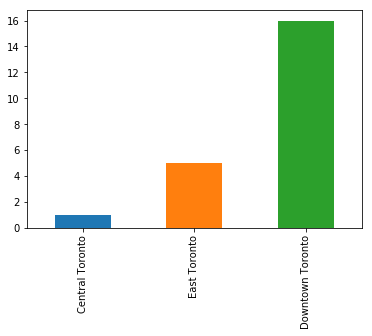

In [33]:
df_cluster0['Borough'].value_counts().sort_values().plot(kind = 'bar')
print("Contribution of boroughs to Cluster 0 (Most of the recommended venues by fourspace API reside in Cluster 0 )")

### We find out the Top Recommended venues on the basis of number of likes for these Top 100 venues. We obtain number likes via sending the URL request to the Foursquare API to get the number of 'likes' stored in the database for each venue.
1. We plot Top 100 Recommended venues on the Toronto map.
2. Green circles represent the Recommended venues
3. We see that the top 100 Recommended venues are largely clustered in Cluster 0. 
4. It also seems both Top 5 Recommended venues and Top 3 restaurants both lie in the M5 Borough. This is code for the Downtown Toronto. 
5. Hence Best Recommneded venues and restaurants lie in Downtown Toronto!! 
6. Below we plot these Top 5 Recommended venues (Yellow hollow rings) and the Top 3 restaurant (Orange hollow rings) on the Toronto map.

In [15]:
df_ven_['likes'] = df_ven_.apply(lambda x: requests.get(likes_ven_url(x['id'])).json()['response']['likes']['count'],axis=1)
df_top_5 = df_ven_.sort_values(by=['likes'],ascending=False).head()
df_top_3_restrnts = df_ven_[df_ven_['categories'].str.contains("Restaurant")].sort_values(by=['likes'],ascending=False)[:3]
display(df_top_5)
display(df_top_3_restrnts)

for lati, lngi, name, category, likes in zip(df_ven_['lat'], df_ven_['lng'], df_ven_['name'], df_ven_['categories'],df_ven_['likes']):
    label = '{}, {}, # of likes: {}'.format(name, category, likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=2,
        popup=label,
        color='green',
        fill=False,
        parse_html=False).add_to(new_map_toronto)
    
for lati, lngi, name, category, likes in zip(df_top_5['lat'], df_top_5['lng'], df_top_5['name'], df_top_5['categories'],df_top_5['likes']):
    label = '</b>{}, {}, # of likes: {}</b>'.format(name, category, likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=5,
        popup=label,
        color='yellow',
        fill=False,
        parse_html=False).add_to(new_map_toronto)

    
for lati, lngi, name, category, likes in zip(df_top_3_restrnts['lat'],df_top_3_restrnts['lng'], df_top_3_restrnts['name'], df_top_3_restrnts['categories'],df_top_3_restrnts['likes']):
    label = '</b>{}, {}, # of likes: {}</b>'.format(name, category, likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=5,
        popup=label,
        color='orange',
        fill=False,
        parse_html=False).add_to(new_map_toronto)
    
new_map_toronto

,name,categories,lat,lng,id,postalCode,likes
53,CN Tower,Monument / Landmark,43.642536,-79.387182,4ad4c05ef964a52096f620e3,M5V 2T6,1991
71,Royal Ontario Museum,Museum,43.668367,-79.394813,4ad4c05ef964a520d9f620e3,M5S 2C6,1489
36,Art Gallery of Ontario,Art Gallery,43.654003,-79.392922,4ad4c05ef964a520daf620e3,M5T 1G4,1314
9,St. Lawrence Market (South Building),Farmers Market,43.648743,-79.371597,4ad4c062f964a520fbf720e3,M5E 1C3,1263
45,TIFF Bell Lightbox,Movie Theater,43.646342,-79.390063,4bcf714ab221c9b67f0ad2d0,M5V 3X5,780


,name,categories,lat,lng,id,postalCode,likes
21,Pai,Thai Restaurant,43.647923,-79.388579,529612de11d2ab526191ccc9,M5H 3G6,668
96,Gusto 101,Italian Restaurant,43.644988,-79.400270,4ee8f32602d5895bd7dce1b1,M5V 2N3,407
67,Seven Lives - Tacos y Mariscos,Mexican Restaurant,43.654418,-79.400545,50427a03e4b08d9f5931f593,M5T 2L6,298


### Conclusion for 1. 
- Based on this Clustering analysis, Downtown Toronto Borough has best venues and the best restaurants to the visiting tourists. 
- Hence, most flux of tourists will be around this area and therefore, it would be advisable to open restaurant that is close to OR in this borough, if the restaurant owners want regular inflow of customers.

###############################################################################################################################
<a id='prop_price'></a>

## 2. Exploring property/estate pricing in the Toronto area for opening restaurant

### We load  the property pricing data of Toronto to analyze which location or area would be suitable for opening a restaurant based on prices. 
### Then we utilize KMeans algorithm to cluster the property location and prices into 3 groups.
1. Low price
2. Medium price
3. High price

### Also note this is 3 dimensional KMeans clustering with features being
- Latitude
- Longitude
- Price

### Notice the Cluster center points' price values ($). 

In [16]:
df_prop = pd.read_csv("Property_Pricing_CLEANED.csv")
df_prop.drop(df_prop.columns[[0]], axis=1,inplace=True)
df_prop.head()
data = df_prop[['Price ($)','lat','lng']]

kmeans = KMeans(n_clusters=3, random_state=42).fit(data)
df_prop["KMeans_Cluster"] = kmeans.predict(data)

low_price_cluster = kmeans.cluster_centers_[0][0]
high_price_cluster = kmeans.cluster_centers_[1][0]
mid_price_cluster = kmeans.cluster_centers_[2][0]

print(kmeans.cluster_centers_)

print("")
print("Cluster center point price values")
print("Low price cluster center in ($): "+ str(low_price_cluster))
print("Medium price cluster center in ($): "+ str(mid_price_cluster))
print("High price cluster center in ($): "+ str(high_price_cluster))


# Saving the datafram and plotting using Tableau
df_prop.reset_index(drop=True).to_csv('Property_Pricing_CLUSTERS_CLEANED.csv')  

[[ 3.48342584e+05  4.36980161e+01 -7.94435907e+01]
 [ 1.30996231e+06  4.37227417e+01 -7.94403229e+01]
 [ 7.21802201e+05  4.37141604e+01 -7.94212793e+01]]

Cluster center point price values
Low price cluster center in ($): 348342.58352873335
Medium price cluster center in ($): 721802.2011585031
High price cluster center in ($): 1309962.3117546905


### We utilize Tableau software for visualization of the clusters and have embedded the plot here
- Low price : Cluster 0
- Medium price : Cluster 2
- High price : Cluster 1

In [17]:
%%HTML
<div class='tableauPlaceholder' id='viz1574288215388' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;KM&#47;KMeans_property_grouping&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='KMeans_property_grouping&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;KM&#47;KMeans_property_grouping&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1574288215388');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Conclusion 2.
- Based on this plot, properties of low to high prices are distributed thoughout the Toronto and are not localized to particular areas. 
- This is good, cause this gives us more options regarding location for opening restaurant. 
- There is a small area where density of green points is high (low price Cluster 0), so this area could be a potential candidate for location, but other factors must be considered which we consider below

###############################################################################################################################
<a id='pref_area_crime_demo'></a>

## 3. Exploring crime, demographics to select preferable areas in Toronto for opening restaurant
1. Crime - Low crime areas are essential as it is necessary that restaurant is able to provide safe and relaxing environment. Crime here is combined metric consisting of - Murders, Thefts, Vehicle Thefts, Robberies, Break & Enters, Sexual Assaults, Assaults, Drug Arrests cases. 

2. Average Family Income - Demographics of high income areas are more likely to have access to leisure income that they are willing to spend on eating out at restaurants.

3. Proximity to tourists visting Toronto.

### We load up the data to analyze and locate these preferable locations

In [18]:
df_well = pd.read_csv("wellbeing_toronto_CLEANED.csv")
df_well.drop(df_well.columns[[0]], axis=1,inplace=True)
df_well.head()

,Neighbourhood,Neighbourhood Id,With Bachelor Degree or Higher,Average Family Income,Healthy Food Index,Pop 25-45 years,Crime,Lat,Lng
0,Rexdale-Kipling,4.0,1620.0,69367.0,23.31,2715.0,127.0,43.721362,-79.565513
1,Elms-Old Rexdale,5.0,1130.0,61196.0,24.71,2265.0,103.0,43.721362,-79.565513
2,Edenbridge-Humber Valley,9.0,5190.0,119581.0,46.41,3550.0,114.0,43.671478,-79.516731
3,Markland Wood,12.0,3525.0,100337.0,7.99,1960.0,67.0,53.578306,-2.479344
4,Etobicoke West Mall,13.0,2705.0,67704.0,15.41,3260.0,76.0,43.628900,-79.559073


### We utilize Tableau software for visualization of the Crime incidences and Average Family Income in Toronto area.

In [19]:
%%HTML
<div class='tableauPlaceholder' id='viz1574288871768' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crime_and_Family_Income&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Crime_and_Family_Income&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crime_and_Family_Income&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1574288871768');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### It seems based on the plot that areas with 'Average Family Income' > 95% Confidence Interval (average) = 96309, shown in gray color, seems to be the best fit for opening restaurant.
- High income areas so people will tend to have more leisure income to spend on the restaurant BUT also these areas have less crime incidences!!

### Hence we will extract areas with areas with > $96309

In [20]:
df_pref = df_well[df_well["Average Family Income"] >= 96309]
del df_pref['Lat'] 
del df_pref['Lng'] 
df_pref.head()

,Neighbourhood,Neighbourhood Id,With Bachelor Degree or Higher,Average Family Income,Healthy Food Index,Pop 25-45 years,Crime
2,Edenbridge-Humber Valley,9.0,5190.0,119581.0,46.41,3550.0,114.0
3,Markland Wood,12.0,3525.0,100337.0,7.99,1960.0,67.0
5,Kingsway South,15.0,4440.0,191204.0,43.15,1725.0,82.0
6,Stonegate-Queensway,16.0,8490.0,100867.0,31.23,6625.0,160.0
21,Banbury-Don Mills,42.0,10850.0,115239.0,21.31,6410.0,171.0


### Functions defined to obtain latitude and longitude of these preferential areas around and in Toronto, based on the name of the place using Nominatim. 
### Also a function to only extract those places that are near the Toronto center latitude and longitude since we would like influx of tourist customers too!

In [21]:
def add_lat(neigh):
    try:
        geolocator = Nominatim(user_agent="newwen",
                            format_string="%s, Toronto Ontario")
        location = geolocator.geocode(neigh)
        lat = location.latitude
    except:
        lat = 99999
        
    return lat



def add_lng(neigh):
    try:
        geolocator = Nominatim(user_agent="newwen",
                            format_string="%s, Toronto Ontario")
        location = geolocator.geocode(neigh)
        lng = location.longitude
    except:
        lng = 99999
        
    return lng



def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))



def closest(data, v):
    return min(data, key=lambda p: distance(v[0],v[1],p[0],p[1]))

In [22]:
df_pref['Lat'] = df_pref.apply(lambda x: add_lat(x['Neighbourhood']),axis=1)

In [23]:
df_pref['Lng'] = df_pref.apply(lambda x: add_lng(x['Neighbourhood']),axis=1)

In [24]:
df_pref.drop(df_pref[(abs(df_pref['Lat'] - toto_latitude) > 0.3) | (abs(df_pref['Lng'] - toto_longitude) > 0.3)].index, inplace=True)

### Thus below are the 14 preferential neighbourhood in Toronto where we it would advisable to open restaurants considering
- Crime incidences
- Average Family Income
- Proximity to tourists visiting Toronto

In [25]:
df_pref.reset_index(drop=True).to_csv('recommended_neighbourhood.csv') 
df_pref

,Neighbourhood,Neighbourhood Id,With Bachelor Degree or Higher,Average Family Income,Healthy Food Index,Pop 25-45 years,Crime,Lat,Lng
2,Edenbridge-Humber Valley,9.0,5190.0,119581.0,46.41,3550.0,114.0,43.671478,-79.516731
21,Banbury-Don Mills,42.0,10850.0,115239.0,21.31,6410.0,171.0,43.734804,-79.357243
40,The Beaches,63.0,9235.0,139757.0,31.53,5870.0,207.0,43.671024,-79.296712
59,High Park-Swansea,87.0,10665.0,116465.0,46.53,8085.0,187.0,43.644940,-79.478313
61,Runnymede-Bloor West Village,89.0,4165.0,114798.0,45.64,2940.0,82.0,43.651778,-79.475923
65,Annex,95.0,16590.0,141111.0,38.85,11485.0,471.0,43.670338,-79.407117
67,Yonge-St.Clair,97.0,6775.0,173751.0,32.65,4320.0,78.0,43.688210,-79.394004
69,Yonge-Eglinton,100.0,6255.0,140907.0,31.95,4225.0,144.0,43.706748,-79.398327
71,Lawrence Park South,103.0,7880.0,216754.0,37.53,3390.0,93.0,43.729199,-79.403252
74,Humewood-Cedarvale,106.0,6060.0,105770.0,32.85,5045.0,110.0,43.690248,-79.422097


### Then it would be useful to assign property pricing cluster (from cluster 0-2) to each of these preferential places in Toronto. This exercise will provide us an idea about the pricing to be expected for opening restaurant in these areas 
- we do this via finding the nearest property to each of these preferential places from the property pricing cluster shown before and then approximating that the preferential neighbourhood belongs to the same cluster.
- 

In [26]:
tempDataList = df_prop[['lat','lng']].values

clos_lat = []
clos_lng = []
clos_clus = []

for x in (df_pref[['Lat','Lng']].values):
    v = [x[0], x[1]]
    clos = closest(tempDataList, v)
    print(clos)
    clos_lat.append(clos[0])
    clos_lng.append(clos[1])
    clos_clus.append(df_prop[(df_prop['lat'] == clos[0]) & (df_prop['lng'] == clos[1])]['KMeans_Cluster'].values[0])
print(clos_clus)

df_pref['Clos_propty_lat'] = clos_lat
df_pref['Clos_propty_lng'] = clos_lat
df_pref['KMeans_Cluster_basedon_Clos_propty'] = clos_clus
df_pref

[ 43.675777 -79.507919]
[ 43.732933 -79.346291]
[ 43.670822 -79.297592]
[ 43.648193 -79.479431]
[ 43.64967  -79.476456]
[ 43.671066 -79.401443]
[ 43.688316 -79.394531]
[ 43.707275 -79.399559]
[ 43.728615 -79.402267]
[ 43.688499 -79.414642]
[ 43.790985 -79.152229]
[ 43.790642 -79.176041]
[ 43.692017 -79.384277]
[ 43.688797 -79.411438]
[0, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1]


,Neighbourhood,Neighbourhood Id,With Bachelor Degree or Higher,Average Family Income,Healthy Food Index,Pop 25-45 years,Crime,Lat,Lng,Clos_propty_lat,Clos_propty_lng,KMeans_Cluster_basedon_Clos_propty
2,Edenbridge-Humber Valley,9.0,5190.0,119581.0,46.41,3550.0,114.0,43.671478,-79.516731,43.675777,43.675777,0
21,Banbury-Don Mills,42.0,10850.0,115239.0,21.31,6410.0,171.0,43.734804,-79.357243,43.732933,43.732933,0
40,The Beaches,63.0,9235.0,139757.0,31.53,5870.0,207.0,43.671024,-79.296712,43.670822,43.670822,0
59,High Park-Swansea,87.0,10665.0,116465.0,46.53,8085.0,187.0,43.644940,-79.478313,43.648193,43.648193,2
61,Runnymede-Bloor West Village,89.0,4165.0,114798.0,45.64,2940.0,82.0,43.651778,-79.475923,43.649670,43.649670,2
65,Annex,95.0,16590.0,141111.0,38.85,11485.0,471.0,43.670338,-79.407117,43.671066,43.671066,0
67,Yonge-St.Clair,97.0,6775.0,173751.0,32.65,4320.0,78.0,43.688210,-79.394004,43.688316,43.688316,2
69,Yonge-Eglinton,100.0,6255.0,140907.0,31.95,4225.0,144.0,43.706748,-79.398327,43.707275,43.707275,2
71,Lawrence Park South,103.0,7880.0,216754.0,37.53,3390.0,93.0,43.729199,-79.403252,43.728615,43.728615,1
74,Humewood-Cedarvale,106.0,6060.0,105770.0,32.85,5045.0,110.0,43.690248,-79.422097,43.688499,43.688499,2


In [27]:
df_pref.reset_index(drop=True,inplace=True)
df_pref.groupby('KMeans_Cluster_basedon_Clos_propty')["Neighbourhood"].nunique()

KMeans_Cluster_basedon_Clos_propty
0    4
1    3
2    7
Name: Neighbourhood, dtype: int64

### Based on this analysis, we see that the 14 preferred areas in Toronto for opening a restaurant belong to property pricing cluster as follows:
1. 4 areas in Cluster 0 (Low price cluster)
2. 3 areas in Cluster 1 (High price cluster)
3. 7 areas in Cluster 2 (Medium price cluster)

###############################################################################################################################
<a id='map_pref_area'></a>

## 4. Analyzing, visualizing preferable areas and competing restaurants in Toronto to finalize recommendations
- Red points are the postcodes that contain the most recommended venues for tourists (Obtained from KMeans, see 1.)
- Orange pinpoint markers refer to Cluster 0 i.e. the low price cluster (~\$350K)
- Purple pinpoint markers refer to Cluster 1 i.e. the high price cluster (~\$1.3M)
- Cadetblue pinpoint markers refer to Cluster 2 i.e. the Medium price cluster (~\$700K)

In [28]:
# create map of Toronto using latitude and longitude values
update_map_toronto = folium.Map(location=[toto_latitude, toto_longitude], zoom_start=11)

# add colored markers corresponding to different clusters
for lat, lng, borough, postcode, cluster in zip(df_toto['Latitude'], df_toto['Longitude'], df_toto['Borough'], df_toto['Postcode'], df_toto['Cluster']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    if cluster == 0:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=1,
            parse_html=False).add_to(update_map_toronto)
    if cluster == 1:
            folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=1,
            parse_html=False).add_to(update_map_toronto)



# add colored markers corresponding to different clusters
for lat, lng, Neighbourhood, cluster in zip(df_pref['Lat'], df_pref['Lng'], df_pref['Neighbourhood'], df_pref['KMeans_Cluster_basedon_Clos_propty']):
    label = '{}, {}'.format(Neighbourhood, cluster)
    label = folium.Popup(label, parse_html=True)
    if cluster == 0:
        folium.Marker(
            [lat, lng],
            popup=label,
            icon=folium.Icon(color='orange')).add_to(update_map_toronto)
    if cluster == 1:
        folium.Marker(
            [lat, lng],
            popup=label,
            icon=folium.Icon(color='purple')).add_to(update_map_toronto)
    if cluster == 2:
        folium.Marker(
            [lat, lng],
            popup=label,
            icon=folium.Icon(color='cadetblue')).add_to(update_map_toronto)



folium.Marker([toto_latitude, toto_longitude], icon=folium.Icon(color='pink'), popup='<b>Toronto Center</b>').add_to(update_map_toronto)


update_map_toronto

### We see that two areas are much further from Borough 0 (red points), which has the most recommended venues. Hence, we remove these points.

In [29]:
df_pref = df_pref[(df_pref['Neighbourhood'] != 'Centennial Scarborough') & (df_pref['Neighbourhood'] != 'Highland Creek')]
df_pref.reset_index(drop=True,inplace=True)
display(df_pref)
df_pref.groupby('KMeans_Cluster_basedon_Clos_propty')["Neighbourhood"].nunique()

,Neighbourhood,Neighbourhood Id,With Bachelor Degree or Higher,Average Family Income,Healthy Food Index,Pop 25-45 years,Crime,Lat,Lng,Clos_propty_lat,Clos_propty_lng,KMeans_Cluster_basedon_Clos_propty
0,Edenbridge-Humber Valley,9.0,5190.0,119581.0,46.41,3550.0,114.0,43.671478,-79.516731,43.675777,43.675777,0
1,Banbury-Don Mills,42.0,10850.0,115239.0,21.31,6410.0,171.0,43.734804,-79.357243,43.732933,43.732933,0
2,The Beaches,63.0,9235.0,139757.0,31.53,5870.0,207.0,43.671024,-79.296712,43.670822,43.670822,0
3,High Park-Swansea,87.0,10665.0,116465.0,46.53,8085.0,187.0,43.644940,-79.478313,43.648193,43.648193,2
4,Runnymede-Bloor West Village,89.0,4165.0,114798.0,45.64,2940.0,82.0,43.651778,-79.475923,43.649670,43.649670,2
5,Annex,95.0,16590.0,141111.0,38.85,11485.0,471.0,43.670338,-79.407117,43.671066,43.671066,0
6,Yonge-St.Clair,97.0,6775.0,173751.0,32.65,4320.0,78.0,43.688210,-79.394004,43.688316,43.688316,2
7,Yonge-Eglinton,100.0,6255.0,140907.0,31.95,4225.0,144.0,43.706748,-79.398327,43.707275,43.707275,2
8,Lawrence Park South,103.0,7880.0,216754.0,37.53,3390.0,93.0,43.729199,-79.403252,43.728615,43.728615,1
9,Humewood-Cedarvale,106.0,6060.0,105770.0,32.85,5045.0,110.0,43.690248,-79.422097,43.688499,43.688499,2


KMeans_Cluster_basedon_Clos_propty
0    4
1    3
2    5
Name: Neighbourhood, dtype: int64

### Let's look at the competition. We plot green circle markers on the map that corresponds to other restaurants in the Toronto area

In [30]:
df_restrnts = df_ven_[df_ven_['categories'].str.contains("Restaurant")].sort_values(by=['likes'],ascending=False)
df_restrnts.reset_index(drop=True,inplace=True)
df_restrnts

,name,categories,lat,lng,id,postalCode,likes
0,Pai,Thai Restaurant,43.647923,-79.388579,529612de11d2ab526191ccc9,M5H 3G6,668
1,Gusto 101,Italian Restaurant,43.644988,-79.400270,4ee8f32602d5895bd7dce1b1,M5V 2N3,407
2,Seven Lives - Tacos y Mariscos,Mexican Restaurant,43.654418,-79.400545,50427a03e4b08d9f5931f593,M5T 2L6,298
3,Bar Isabel,Tapas Restaurant,43.654782,-79.420717,514a4961e4b004a36b8d9ea0,M6G 1C7,293
4,Wilbur Mexicana,Mexican Restaurant,43.644810,-79.398644,544fc36c498ea63958331891,M5V 1M3,292
5,Bar Raval,Tapas Restaurant,43.655904,-79.410125,54e0dc87498ecbdb39a0fade,M6J 2J3,261
6,Richmond Station,American Restaurant,43.651569,-79.379266,506db1a9e4b0a3f3b31412f0,NaN,249
7,Byblos Toronto,Mediterranean Restaurant,43.647615,-79.388381,5321f4d9e4b07946702e6e08,M5V 3M2,242
8,Union Restaurant,New American Restaurant,43.645860,-79.419532,4ada6d8df964a520832221e3,NaN,179
9,Rodney's Oyster House,Seafood Restaurant,43.644975,-79.396587,4af0c5c1f964a5200fdf21e3,M5V 1K4,177


In [31]:
# add colored markers corresponding to different clusters
for lat, lng, likes in zip(df_restrnts['lat'], df_restrnts['lng'], df_restrnts['likes']):
    label = '# of likes: {}'.format(likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(update_map_toronto)

update_map_toronto

### Let's look at the unique categories of these restaurants

In [32]:
df_restrnts_grp = df_restrnts.groupby('categories')["likes"].describe()
df_restrnts_grp.drop(['std','25%','50%','75%'],axis=1,inplace=True)
df_restrnts_grp.sort_values('count', ascending=False)

,count,mean,min,max
categories,,,,
Restaurant,3.0,64.0,40.0,78.0
Italian Restaurant,2.0,290.5,174.0,407.0
Mediterranean Restaurant,2.0,145.5,49.0,242.0
Mexican Restaurant,2.0,295.0,292.0,298.0
Tapas Restaurant,2.0,277.0,261.0,293.0
Thai Restaurant,2.0,369.5,71.0,668.0
American Restaurant,1.0,249.0,249.0,249.0
French Restaurant,1.0,74.0,74.0,74.0
New American Restaurant,1.0,179.0,179.0,179.0


### The cuisine offered then by other restaurants are:
1. American
2. French
3. Italian
4. Mediterranean
5. Mexican
6. New American
7. Ramen
8. Unknown
9. Seafood
10. Tapas
11. Thai
12. Theme

###############################################################################################################################
<a id='final_rec'></a>

## 5. Final recommedations for opening a restaurant in Toronto

### The finalized preferential area for opening a restaurant are:
1. The Beaches (Orange pinpoint marker, property pricing Cluster-0, (~\$ 350K)
2. Annex (Orange pinpoint marker, property pricing Cluster-0, (~\$ 350K)

### Noteworthy points
- These areas are in the low pricing cluster, hence low investment for buying/renting restaurant property in these areas
- From the property pricing cluster plot in 2. we see that there are a lot of properties available in each pricing cluster, hence lot of choices for buying/renting property
- Both of these areas have very low crime incidences.
- Average Family income in both these areas is > 95% Confidence Interval (average) = 96309. Hence the local demographic has leisure income to spend on eating out in restaurants.
- Both these areas reside in the postcode cluster where resides the most recommended venues in Toronto. So plenty of tourist customer influx is expected in the restaurant opened in these areas.
- An unexpected insight is that these areas are further away from other competing restaurants in the Toronto area, shows by green circle markers, which seem to be quite tightly grouped. Hence, it provides additional advantage that customer doesn't have multiple choices in choosing the restaurant, once they are in the above 2 recommended areas## The finalized cuisine are

### Extra suggestions - Cuisine
- It seems that the new restaurant could offer cuisine not listed above to stand out. Hence, the restaurant owners could go for Indian or Chinese Cuisine.
- 'The Beaches' is by the ocean and hence, opening a Seafood cuisine and restaurant there could be beneficial due to the view of the ocean.
- French or Theme restaurant is also viable since there is only 1 recommended restaurant for each and they don't seem to be very popular either due to few likes as compared to other restaurants and thus might not have established large customer base
- It is advised not to open Italian or Thai restaurants as restaurants for this cuisine are already popular with high amount of likes. Not only that, but multiple recommended restaurants for this cuisine are present in the Toronto area.

###############################################################################################################################